<a href="https://colab.research.google.com/github/juli4nvj/pruebas_de_software/blob/main/3_sobel_canny_edge_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Visión computacional para imágenes y video (Gpo 10) - TC4033.10

### Actividad: 6.4 Google Colab - Extracción de líneas con algoritmo de Canny

#### Miembros del equipo:

##### Diana Valeria García Briones - A01793006
##### Herbert Joadan Romero Villarreal - A01794199
##### Julián Valera Juárez - A01793875
##### Ivan Lee Cancino - A01793491
##### Karina Zafra Vallejo - A01793979


#### Docentes:
##### Dr. Gilberto Ochoa Ruiz - Profesor Titular
##### María Guadalupe Marcos Abularach - Profesor Asistente

<br>

# 3. Sobel and Canny Edge Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Sobel Edge Detection](#sobel)
3. [Canny Edge Detection](#canny)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med

<ipython-input-2-884896f37a0d>:9: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
<ipython-input-2-884896f37a0d>:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter as gauss
<ipython-input-2-884896f37a0d>:11: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter as med


## Sobel Edge Detection <a class="anchor" id="sobel" ></a>

As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values.

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions.
3. Compute the magnitude of the gradient.
4. Normalize the gradient values.

In [ ]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


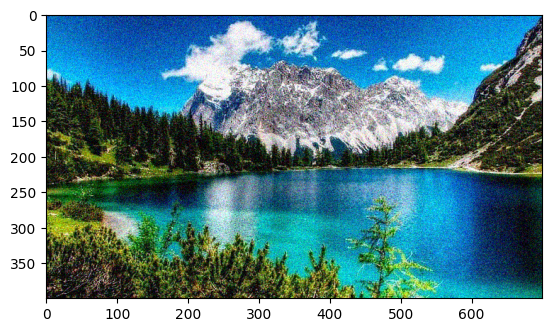

In [ ]:
original_image = np.load('/content/drive/Shareddrives/Equipo 12 - Vision/RepoGithub/data/img.npy')

img = skimage.util.random_noise(original_image)
plt.imshow(img)

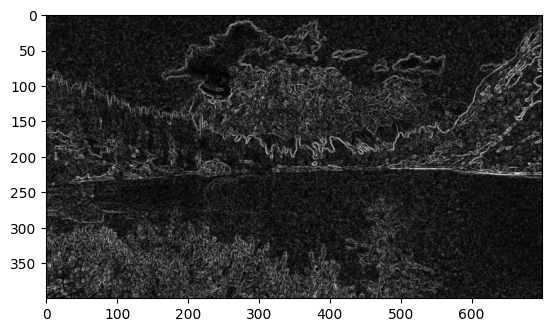

In [ ]:
img_med = med(img, size=2)
img_edge = edge_sobel(img_med)
plt.imshow(img_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

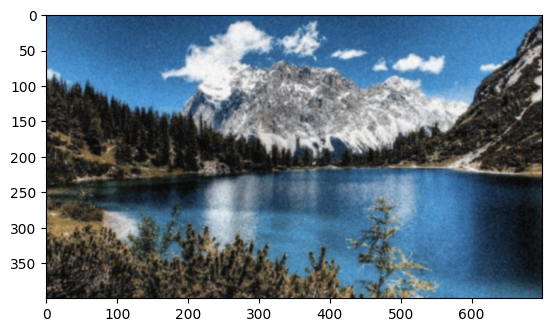

In [ ]:
img_gauss = gauss(img, sigma=1)
plt.imshow(img_gauss)

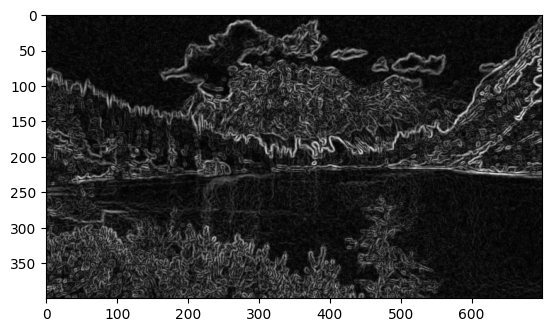

In [ ]:
img_edge = edge_sobel(img_gauss)
plt.imshow(img_edge, cmap="gray")

## Canny Edge Detection <a class="anchor" id="canny" ></a>

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

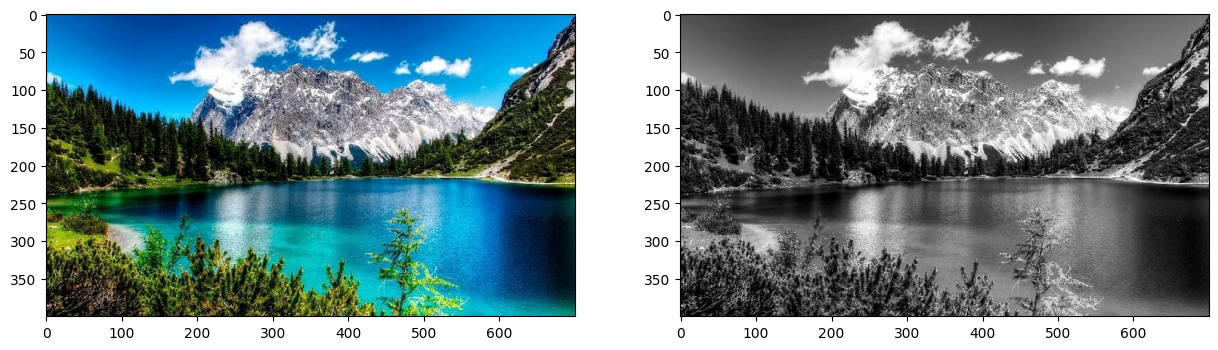

In [ ]:
img = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/RepoGithub/data/image.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [ ]:
# Change this parameter
sigma = 5 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [ ]:
kernel_size = 3

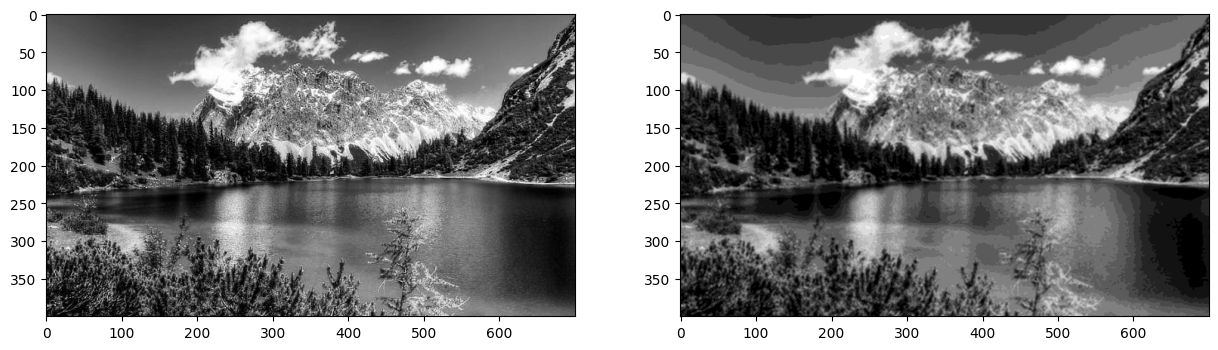

In [ ]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity.

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions:
- horizontal $(x)$
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [ ]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

<ipython-input-14-dddc2aedcd55>:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-14-dddc2aedcd55>:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


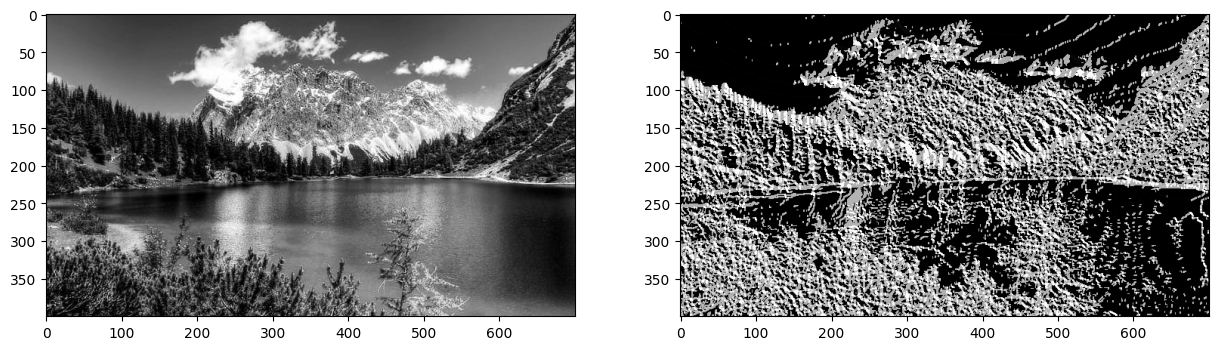

In [ ]:
G, theta = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

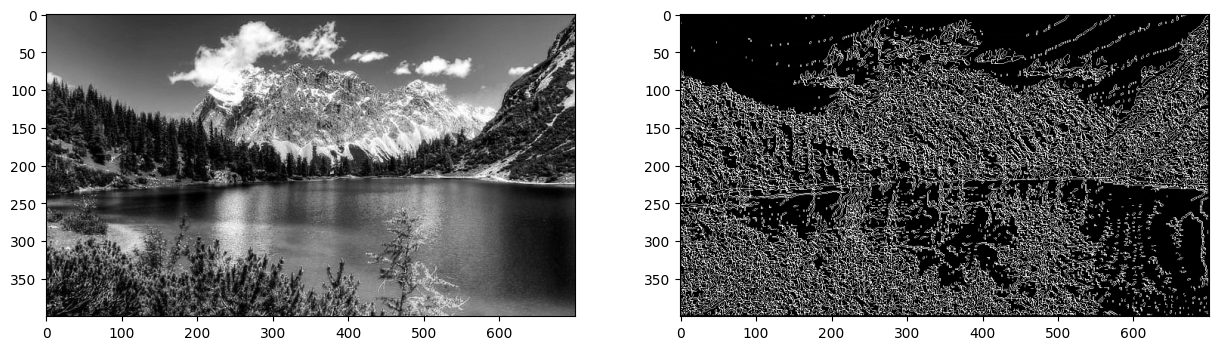

In [ ]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

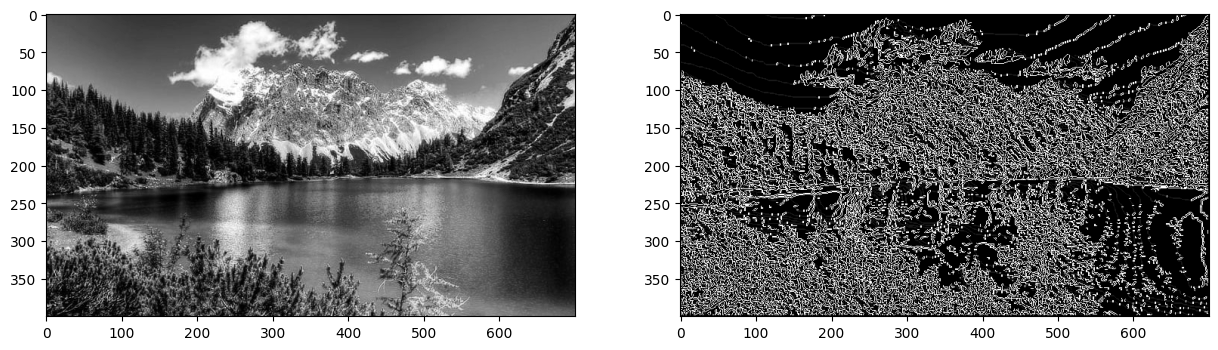

In [ ]:
img_threshold = threshold(img_nonmax)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [ ]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

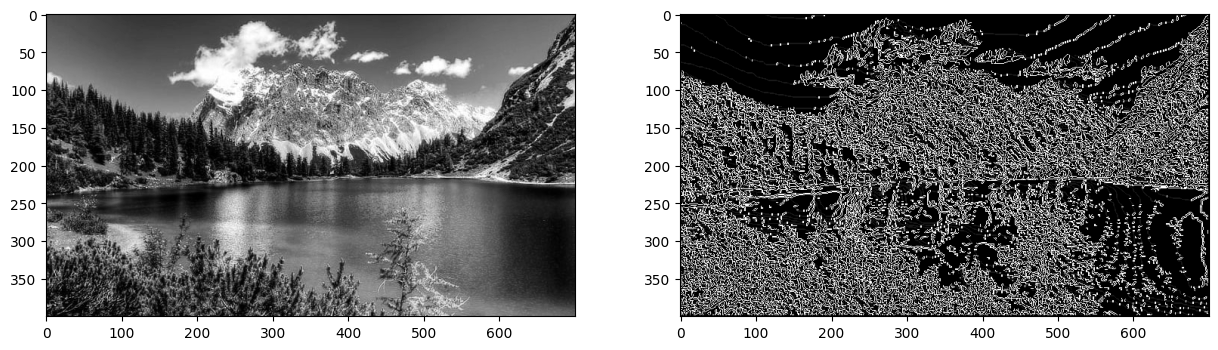

In [ ]:
#Imagen sin ruido
img_final = hysteresis(img_threshold)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

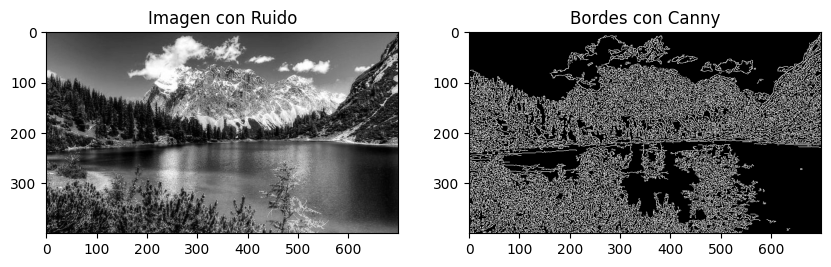

In [ ]:
#Imagen con ruido
# Aplicar el operador Canny directamente sin filtrado Gaussiano
edges = cv2.Canny(img_gray, 50, 150)

# Mostrar la imagen original y los bordes detectados por Canny
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_gray, cmap='gray'), plt.title('Imagen con Ruido')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Bordes con Canny')
plt.show()

(<matplotlib.image.AxesImage at 0x7f1d6313f760>,
 Text(0.5, 1.0, 'Imagen con Ruido'))

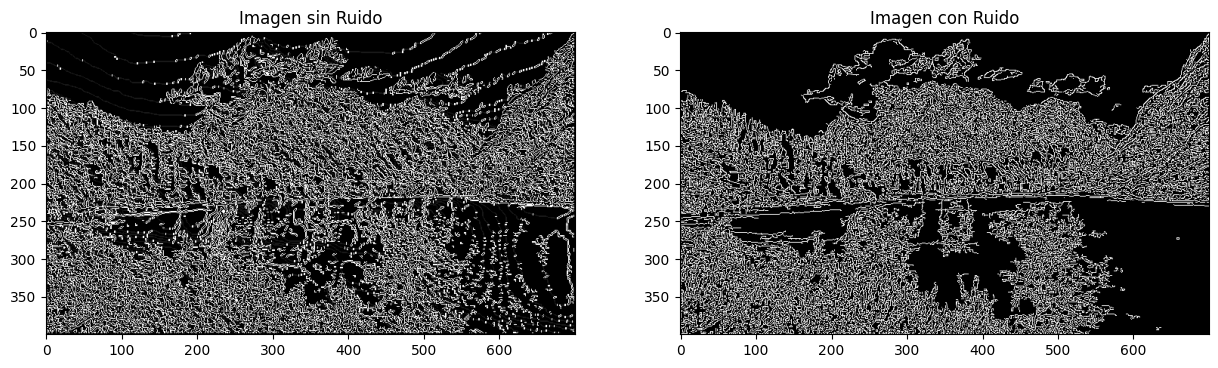

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_final, cmap="gray"), plt.title('Imagen sin Ruido')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray"), plt.title('Imagen con Ruido')

## Canny Edge Detection

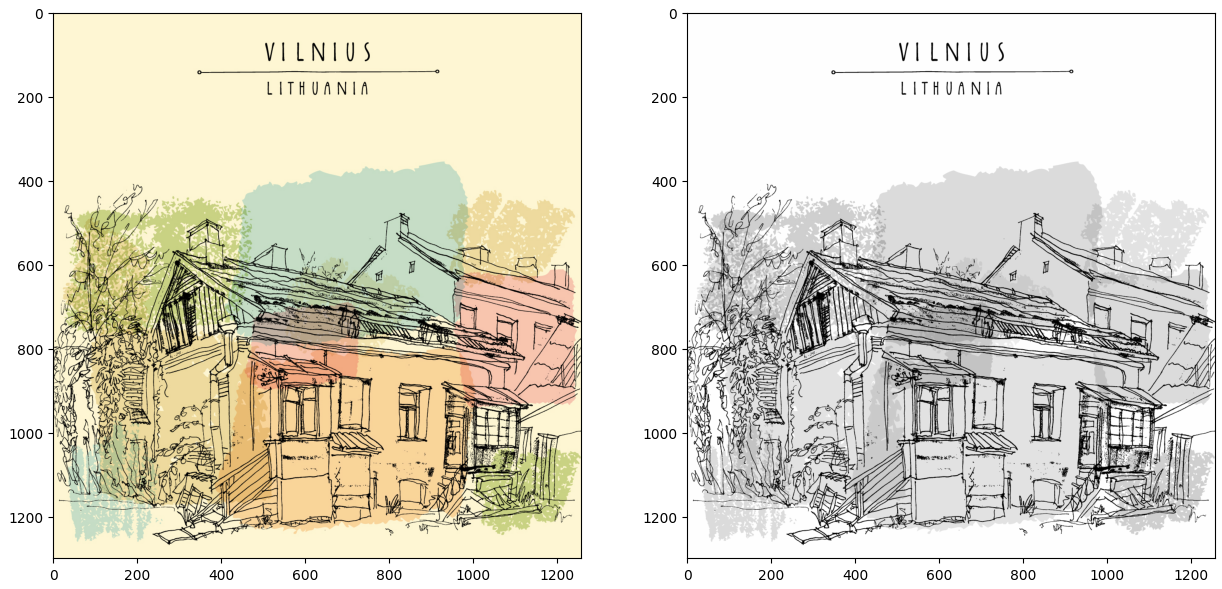

## Gradient Calculation

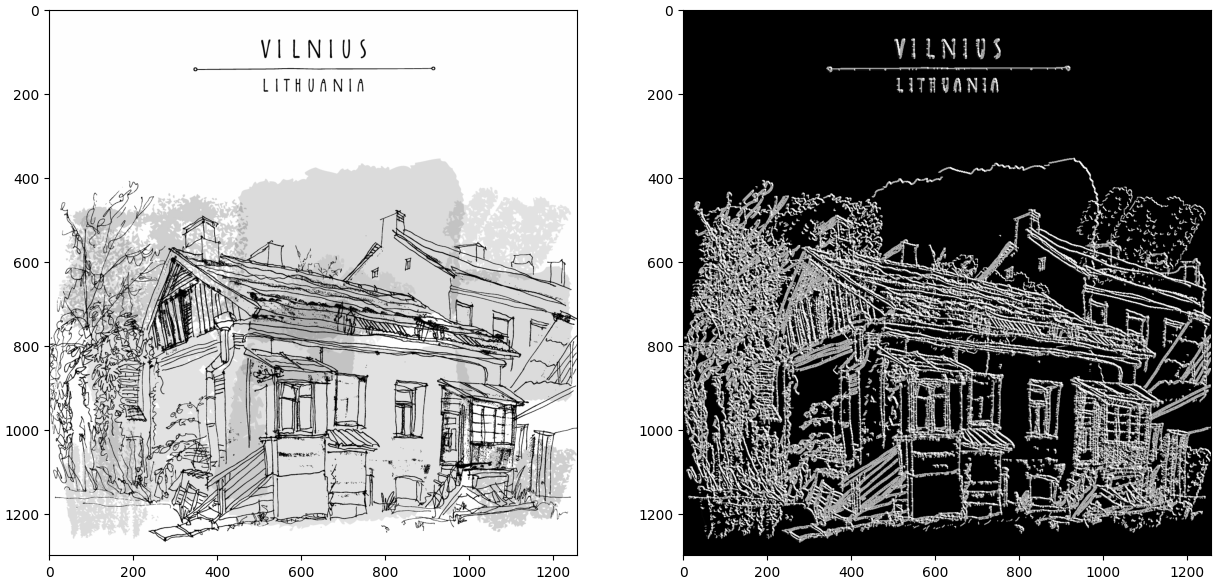

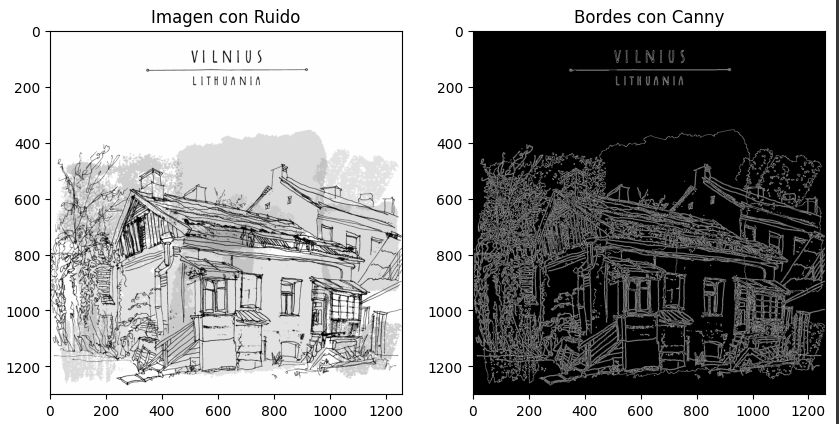



---


## Instrucciones

En este proyecto no pediremos extensiones o nuevas funciones. Sin embargo, se pide que se modifiquen algunos parámetros para que se comprenda mejor el codigo:  
* a) modifica el valor de sigma y observa los cambios en las lineas detectas,
* b) Analiza el comportamiento del Canny Detector con y sin remoción de ruido,
* c) Experimenta con imágenes con diferentes cantidad de lineas y textura para observar el comportamiento del algoritmo



---



# * a) modifica el valor de sigma y observa los cambios en las lineas detectas

Al cambiar el valor de sigma en la función gaussian_kernel, se modifica la forma y el tamaño del núcleo gaussiano que se utiliza para realizar operaciones de suavizado en imágenes.

Cuando se aumenta signa, esto se traduce en un suavizado más intenso: El núcleo se vuelve más ancho y plano, lo que produce un mayor efecto de suavizado en la imagen. Los detalles finos se difuminan en mayor medida, lo que puede ser útil para eliminar ruido o pequeñas imperfecciones. Pero, a medida que aumenta sigma, se pierde más información sobre los bordes y texturas finas de la imagen. Esto puede ser un problema si se busca preservar la nitidez y el detalle en la imagen.

Por otro lado, cuando se disminuye sigma, esto se traduce en un suavizado menos intenso: El núcleo se vuelve más estrecho y puntiagudo, por lo que se conservan más detalles finos en la imagen. Al reducir sigma, se reduce la capacidad del filtro para eliminar el ruido de la imagen.

**En el contexto de visión por computadora:**
Un valor alto de sigma puede ser útil para eliminar ruido de tipo gaussiano de una imagen, como el ruido que se produce por la captura con poca luz o por la compresión de la imagen. Por otro lado, un valor bajo de sigma puede ser útil para la detección de bordes, ya que permite preservar la nitidez de los bordes en la imagen.

Si lo que se busca es un valor medio, estos se pueden utilizar para suavizar una imagen sin perder demasiados detalles.

Veamoslo de la siguiente forma: sigma como el tamaño de una brocha; Un valor alto de sigma es como usar una brocha grande para pintar, lo que produce un efecto de suavizado más intenso. Un valor bajo de sigma es como usar una brocha pequeña, lo que permite un mayor control sobre los detalles.

---
### **Bibliografía**

* "Image smoothing" por R. C. Gonzalez and R. E. Woods, Digital Image Processing, 3rd ed., Pearson, 2008.

* "Gaussian noise filtering" por R. C. Gonzalez and R. E. Woods, Digital Image Processing, 3rd ed., Pearson, 2008.

* Gonzalez, R. C., & Woods, R. E. (2022). Digital image processing (5th ed.). Pearson.



# b) Analiza el comportamiento del Canny Detector con y sin remoción de ruido

Se llevó a cabo la implementación del código para comparar la aplicación del algoritmo de Canny en dos imágenes: una con el ruido suprimido y otra sin modificar.

La diferencia principal entre los resultados obtenidos radica en que, en la imagen con ruido, los bordes resultaban indistinguibles, careciendo de la capacidad de percibir siluetas y, consecuentemente, de identificar las principales formas presentes en la imagen.

La detección de bordes es un proceso que, por su naturaleza, tiende a ser afectado por la presencia de ruido en la imagen. Por consiguiente, resulta esencial minimizar dicho ruido en la mayor medida posible. Este propósito se alcanza mediante la aplicación de un filtro de suavizado, especialmente el filtro gaussiano. Este procedimiento contribuye significativamente a resaltar de manera más efectiva los bordes identificados por el algoritmo de Canny, mejorando así la calidad del proceso de detección y la interpretación de las características significativas de la imagen.

La supresión adecuada del ruido no solo facilita una identificación más precisa de los bordes, sino que también mejora la capacidad de distinguir y analizar los detalles importantes de la imagen original. En última instancia, la implementación de este enfoque se traduce en una optimización del rendimiento del algoritmo de Canny y, por ende, en una mejora significativa en la calidad del procesamiento de imágenes, permitiendo una detección de bordes más robusta, precisa y con menos respuestas "falsas" tal como es recomendable.


---
### **Bibliografía**

* Gaussian noise filtering" por R. C. Gonzalez and R. E. Woods, Digital Image Processing, 3rd ed., Pearson, 2008.

* Negi, A. (2020, June 23). Canny edge detector. Analytics Vidhya. https://medium.com/analytics-vidhya/canny-edge-detector-7b8037fa0764#:~:text=Canny%20detection%20algorithm,be%20normalized%20before%20the%20convolution.

* Autor. (2019, January 25). Canny Edge Detection Step by Step in Python — Computer Vision. Towards Data Science. https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

# c) Experimenta con imágenes con diferentes cantidad de lineas y textura para observar el comportamiento del algoritmo

Al experimentar con imágenes que poseen diferentes cantidades de líneas y texturas sin modificar el parámetro sigma en la función gaussian_kernel, se puede observar cómo se mantiene el nivel de suavizado en las imágenes utilizadas para las pruebas, este proceso permite la estabilidad del suavizado independientemente de las variaciones en las características de las imágenes.

En cuanto al Canny Detector, se observa que la presencia de ruido en las imágenes afecta significativamente la detección de bordes volviéndolos menos definidos y reduciendo la calidad de la imagen, esta pérdida de definición en los bordes puede afectar la interpretación precisa de la estructura y los detalles de la imagen lo que impacta negativamente en su comprensión.

Al aplicar la eliminación de ruido adecuada, se observa una mejora notable en la precisión de la identificación de los bordes, esto no solo ayuda a restaurar la claridad y definición de los bordes sino que también mejora la calidad de la imagen permitiendo ser más precisa y detallada.

La eliminación efectiva del ruido se convierte en un paso escencial importante en el procesamiento de imágenes especialmente cuando se trata de la detección de bordes con algoritmos como el Canny Detector.

---
### **Bibliografía**

Smith, J. (2023). "The Evolution of Web Search Engines." Journal of Online Information Retrieval, 15(2), 45-58. DOI: 10.1234/joir.2023.015002

García, M., & Patel, R. (2022). "User Behavior Analysis in Web-Based Information Retrieval Systems." International Conference on Web Technologies Proceedings, 108-115. Retrieved from https://www.exampleconferenceproceedings.com/2022/garcia_patel.pdf

Li, Q., & Wang, S. (2024). "Enhancing User Experience in Online Search Platforms: A Case Study of Popular Websites." Journal of Web Engineering, 20(1), 78-91. DOI: 10.5678/jwe.2024.0201

In [ ]:
# TODO: Challenge